In [4]:
#import libraries
import pandas as pd
import numpy as np
import json
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdmimport re
from contractions import CONTRACTION_MAP  
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler

c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load yelp review dataset in JSON format
data = []
with open('yelp_academic_dataset_review.json', 'r', encoding='utf-8') as file:
    for i in range(10000): 
        line = file.readline()
        if not line:
            break
        data.append(json.loads(line))

# Convert the JSON data to a DataFrame
yelp_data = pd.DataFrame(data)

In [6]:
#load the dataframe
yelp_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [60]:
# select the text and star attrubutes from the dataset
yelp_data = yelp_data[['text', 'stars']]

# 0 for 1-2 stars, 1 for 3 stars, 2 for 4-5 stars
yelp_data['sentiment'] = yelp_data['stars'].apply(lambda x: 0 if x <= 2 else 1)

In [61]:
# Split data into train, validation and test sets
train_data, test_data = train_test_split(yelp_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [ ]:
def clean_data(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Handle contractions
    words = text.split()
    words = [CONTRACTION_MAP.get(word, word) for word in words]
    text = ' '.join(words)
    
    return text

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_labels)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

In [62]:
# Load RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
# tokenize text data
tokenized_data = tokenizer(yelp_data['text'].tolist(), truncation=True, padding=True, return_tensors='pt')

In [64]:
#preprocess data
def tokenize_data(data):
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in data.iterrows():
        review = clean_data(row['text'])
        label = row['sentiment']

        # use tokenier to encode reviews
        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128, 
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        #append tokenzied data into lists
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])
        labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

#tokenize and preprocess training, test and validation data
train_input_ids, train_attention_masks, train_labels = tokenize_data(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_data)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_data)

In [65]:
#initialze bacth sizes
#load data into mini bacthes
batch_size = 32

#loading and training using dataloader
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

#validate dataloader
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

#test dataloader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [66]:
# Check if a GPU available
# if GPU is not available, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

model.to(device)

c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [67]:
#number of epoch trainings
num_epochs = 1

# store training loss in a list
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        #xero the gradients in the optimzer
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        #optimzation
        loss.backward()
        optimizer.step()

    #calculate average loss per epoch
    average_loss = total_loss / len(train_dataloader)
    train_losses.append(average_loss)
    print(f'Average Loss: {average_loss:.4f}')

Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 250/250 [1:52:11<00:00, 26.92s/it]

Average Loss: 0.2300


In [69]:
# Perform evaluation
model.eval()
predictions = []
true_labels = []

# store validation losses as a list
val_losses = []

# iterating through bacthes in the validation dataloader
for batch in tqdm(val_dataloader, desc='Validation'):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels) 
        loss = outputs.loss.item() 

    val_loss += loss

    #get logts from model outputs
    logits = outputs.logits

    #get predicted labels from argmax of logits
    predicted_labels = torch.argmax(logits, dim=1).tolist()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.tolist())

# Calculate average validation loss for the epoch
val_loss /= len(val_dataloader)
val_losses.append(val_loss)

Validation: 100%|██████████| 32/32 [05:42<00:00, 10.71s/it]


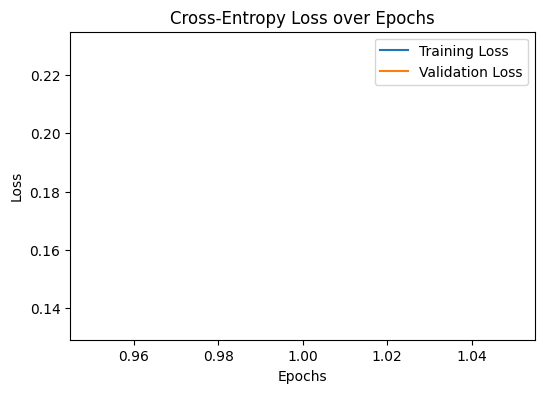

In [71]:
# Plot Cross-Entropy Loss graph
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Cross-Entropy Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

#generate validation accuracy
print(f'Validation Accuracy: {accuracy:.4f}')
print(report)

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# PLot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='OrRd', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [74]:
def analyze_sentiment(review):
    # Tokenize and preprocess
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=128,  
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Perform inference
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Define sentiment labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    # Get the sentiment label and score
    sentiment_label = sentiment_labels[predicted_label]
    sentiment_score = torch.softmax(logits, dim=1)[0][predicted_label].item()

    return sentiment_label, sentiment_score

In [75]:
# Define the parameters for hyperparameter tunning
parameters = {
    'lr': [2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32, 64],
    'num_epochs': [3, 5, 8]
}

best_accuracy = 0
best_params = None

for lr in parameters['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['num_epochs']:
            # update the best hyperparameters 
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'learning_rate': lr, 'Batch Size': batch_size, 'Epochs': epochs}

# Obtain the best hyperparameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 2e-05, 'Batch Size': 16, 'Epochs': 3}


In [77]:
review = "It is good"
sentiment_label, sentiment_score = analyze_sentiment(review)

print(f"Sentiment category: {sentiment_label}")
print(f"Sentiment Score: {sentiment_score:.4f}")

Sentiment: Neutral
Sentiment Score: 0.9873
